## Clustering of Crypto Currencies by Categorical Information
- Prepared the data to remove inappropriate values
- Applied PCA to reduce dimensionality
- Clustered principle components with KMEANS

Notes:  
1.  Additional PCA plots were developed  
1.  Further investigation about the stochastic effects of KMEANS is needed.  I feel that I should do a bootstrapping type evaluation 
1.  Currently adding cluster analysis section  

In [70]:
## Using Environment PythonDataS2022
# !pip install path
# !pip install plotly-express
# !pip install numpy==1.21.6
# !jupyter labextension list

In [71]:
# added to prevent warnings when KMEANS executes
# solves issue involving memory leakage
import os
os.environ["OMP_NUM_THREADS"] = "3"

In [72]:
# Dependencies
import pandas as pd
# import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [73]:
# access data
df = pd.read_csv('data/crypto_data.csv')

In [74]:
# rename columns to be more pythonic
df.columns = ['id', 'name', 'algorithm', 'is_trading', 'proof_type',
       'mined_coins', 'total_coins']

In [75]:
# review data
# - Problems: see mined_coins as NaN and some total_coins are zero
df.head()

,id,name,algorithm,is_trading,proof_type,mined_coins,total_coins
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [76]:
# check data types
df.dtypes

id              object
name            object
algorithm       object
is_trading        bool
proof_type      object
mined_coins    float64
total_coins     object
dtype: object

In [77]:
# total_coins should be integer
df[df.total_coins.isna()]

,id,name,algorithm,is_trading,proof_type,mined_coins,total_coins


In [78]:
# Remove spaces and periods that seem to represent commas 
df.total_coins = df.total_coins.apply(lambda x: x.replace(" ", ""))
df.total_coins = df.total_coins.apply(lambda x: x.replace(".", ""))

In [79]:
# column is represented by common numeric values - not convert data type
df.total_coins = pd.to_numeric(df.total_coins)

In [80]:
# check data types
df.dtypes

id              object
name            object
algorithm       object
is_trading        bool
proof_type      object
mined_coins    float64
total_coins      int64
dtype: object

In [81]:
# number of records
len(df)

1252

In [82]:
# find where not a number values are located
df.isna().sum()

id               0
name             0
algorithm        0
is_trading       0
proof_type       0
mined_coins    508
total_coins      0
dtype: int64

In [83]:
# find the min/max values of numeric columns
# min values less than or equal to zero should not be possible
# total coins shows that some values are 0
df.describe()

,mined_coins,total_coins
count,7.440000e+02,1.252000e+03
mean,3.883103e+09,1.686726e+15
std,3.867263e+10,4.012377e+16
min,-5.917978e+09,0.000000e+00
25%,6.322164e+05,1.800000e+07
50%,1.340427e+07,6.000000e+07
75%,9.399895e+07,4.000000e+08
max,9.899887e+11,1.004466e+18


In [84]:
# remove not a number rows and values that are zero 
df = df[~df.mined_coins.isna()]
df_clean = df[df.total_coins > 0]

In [85]:
# review data
df_clean.describe()

,mined_coins,total_coins
count,6.960000e+02,6.960000e+02
mean,3.777201e+09,1.581953e+15
std,3.958846e+10,3.822921e+16
min,-5.917978e+09,4.200000e+01
25%,6.583474e+05,2.100000e+07
50%,1.304427e+07,8.400000e+07
75%,8.358780e+07,5.000000e+08
max,9.899887e+11,1.004466e+18


In [86]:
# check for not a number
df_clean.isna().sum()

id             0
name           0
algorithm      0
is_trading     0
proof_type     0
mined_coins    0
total_coins    0
dtype: int64

In [87]:
# total records
len(df_clean)

696

### Evaluate the columns for enough values

In [88]:
# inspect is_trading - highly skewed towards true - consider throwing out column or Falses
df_clean.is_trading.value_counts()

True     637
False     59
Name: is_trading, dtype: int64

In [89]:
# inspect algorithm - many low values 
tmp = df_clean.algorithm.value_counts()
tmp

Scrypt                   229
X11                       98
SHA-256                   69
CryptoNight               24
Quark                     23
                        ... 
SkunkHash v2 Raptor        1
VeChainThor Authority      1
Ouroboros                  1
POS 2.0                    1
TRC10                      1
Name: algorithm, Length: 81, dtype: int64

In [90]:
# inspect algorithm to see larger values
tmp.loc[lambda x: x > 10]

Scrypt         229
X11             98
SHA-256         69
CryptoNight     24
Quark           23
Equihash        20
X13             20
PoS             18
NeoScrypt       17
Ethash          13
NIST5           11
Name: algorithm, dtype: int64

In [91]:
# inspect proof_type 
temp = df_clean.proof_type.value_counts()
temp

PoW                     326
PoW/PoS                 231
PoS                     106
DPoS                      8
PoC                       3
PoS/PoW                   2
DPoW                      1
LPoS                      1
DPoC                      1
Proof of Trust            1
POS / MN                  1
Pos                       1
DPOS                      1
Zero-Knowledge Proof      1
HPoW                      1
PoW + Hive                1
PoA                       1
POBh                      1
PoW and PoS               1
Proof of Authority        1
PoW/PoS                   1
TPoS                      1
PoW/PoW                   1
dPoW/PoW                  1
PoW/nPoS                  1
PoS/LPoS                  1
Name: proof_type, dtype: int64

In [92]:
# converted view to an independent dataframe
df_clean = df_clean.copy()

### Check for relation between algorithm and proof_type

In [93]:
# inpect the combinations of algorithm and proof_type
df_clean['combo']= df_clean.loc[:, 'proof_type'] +"/"+ df_clean.loc[:, 'algorithm']

In [94]:
df_clean.head()

,id,name,algorithm,is_trading,proof_type,mined_coins,total_coins,combo
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42,PoW/PoS/Scrypt
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000,PoW/PoS/Scrypt
5,1337,EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359,PoW/PoS/X13
7,BTC,Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000,PoW/SHA-256
9,LTC,Litecoin,Scrypt,True,PoW,6.303924e+07,84000000,PoW/Scrypt


In [95]:
# inspect combinations
temp = df_clean.combo.value_counts()
temp

PoW/Scrypt              103
PoW/PoS/Scrypt           90
PoW/PoS/X11              49
PoW/SHA-256              41
PoW/X11                  34
                       ... 
PoW/Blake2b               1
PoW/PoS/536               1
PoW/PoS/Blake2S           1
PoW/Dagger-Hashimoto      1
DPoS/SHA-256              1
Name: combo, Length: 138, dtype: int64

In [96]:
# inspect larger combinations
# POW and POS have many algorithms - no single dominant factor - the distinction will probably help with clustering
temp.loc[lambda x: x > 5]

PoW/Scrypt          103
PoW/PoS/Scrypt       90
PoW/PoS/X11          49
PoW/SHA-256          41
PoW/X11              34
PoS/Scrypt           29
PoW/CryptoNight      24
PoW/PoS/SHA-256      19
PoS/PoS              17
PoW/Equihash         16
PoW/PoS/X13          13
PoS/X11              13
PoW/Ethash           12
PoW/NeoScrypt        12
PoS/Quark             9
PoW/PoS/NIST5         8
PoW/PoS/Quark         8
PoS/SHA-256           8
PoW/PoS/SHA-256D      7
PoW/Multiple          7
PoS/X13               6
Name: combo, dtype: int64

In [97]:
# here is a better way of analyzing

# shows count of algorithm per proof_type
temp = df_clean.groupby(['algorithm', 'proof_type']).count()['total_coins']
temp.rename('counts', inplace=True)

# shows percentage of algorithm per proof_type
temp2 = temp.groupby(level=0).apply(lambda x: 100*x/float(x.sum())).to_frame()
temp2.columns=['percent']

# shows max percent of algorithm group
temp3 = temp.groupby(level=0).apply(lambda x: max(100*x/float(x.sum()))).to_frame()
temp3.columns=['max_percent']

# combine 3 dataframes
temp_new = temp2.join(temp.reindex(temp2.index, level=0))
temp_final = temp_new.join(temp3.reindex(temp2.index, level=0))

# Add sum of counts column
temp_final['total_count'] = (temp_final['counts']/(temp_final['percent']/100)).astype(int)

# create filter of algorithm group with max value of proof_type is less than 80% with more than 5 records
filter_results = temp_final[(temp_final.max_percent <= 80) & (temp_final.total_count > 5)]

# display all results
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(filter_results)

                          percent  counts  max_percent  total_count
algorithm proof_type                                               
Equihash  DPoW              5.000       1       80.000           20
          PoS               5.000       1       80.000           20
          PoW              80.000      16       80.000           20
          PoW/PoS           5.000       1       80.000           20
          dPoW/PoW          5.000       1       80.000           20
Multiple  PoS              11.111       1       77.778            9
          PoW              77.778       7       77.778            9
          PoW/PoS          11.111       1       77.778            9
NIST5     PoS               9.091       1       72.727           11
          PoW              18.182       2       72.727           11
          PoW/PoS          72.727       8       72.727           11
NeoScrypt PoW              70.588      12       70.588           17
          PoW/PoS          29.412       5       

In [98]:
filter_results.counts.sum()

503

* The above results show that there are only 10 algorithms with a variety of proof types and more than 5 records.  
* There are 696 records and 503 of these represent different proof types, but almost half of these records are represented by Scrypt algorithm.  
*  The proof_type might need to be better classified or generalized.  
* Since so many records don't have a clear relationship between algorithms and proof_type, the two variables will be assumed to be independent.  

In [99]:
# Above results show th

# # view new df
# filter_results.head()

In [100]:
# no longer need combo or id columns and set name as the index for easy viewing and analysis
df_clean.drop('combo', axis=1, inplace=True)
df_clean.drop('id', axis=1, inplace=True)
df_clean.set_index('name',inplace=True)

In [101]:
# view dataframe
df_clean.head()

,algorithm,is_trading,proof_type,mined_coins,total_coins
name,,,,,
42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359
Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000
Litecoin,Scrypt,True,PoW,6.303924e+07,84000000


### Convert categorical columns to numeric

In [102]:
# convert categorical values to one-hot-encoded values
# since this is clustering I don't think there is a benefit of aggregating less common records into a single category
# maybe check reduction of labels as a potential improvement but probably not needed for clustering
df_encoded = pd.get_dummies(df_clean)

# create new copy of dataframe
# - df_base_encoded is standard encoded dataframe
# - df_encoded is a dataframe that will have modifed one-hot-encoded columns
df_base_encoded = df_encoded.copy()
df_encoded.head()

,is_trading,mined_coins,total_coins,algorithm_1GB AES Pattern Search,algorithm_536,algorithm_Argon2,algorithm_BLAKE256,algorithm_Blake,algorithm_Blake2S,algorithm_Blake2b,...,proof_type_PoW/PoS,proof_type_PoW/PoS,proof_type_PoW/PoW,proof_type_PoW/nPoS,proof_type_Pos,proof_type_Proof of Authority,proof_type_Proof of Trust,proof_type_TPoS,proof_type_Zero-Knowledge Proof,proof_type_dPoW/PoW
name,,,,,,,,,,,,,,,,,,,,,
42 Coin,True,4.199995e+01,42,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404Coin,True,1.055185e+09,532000000,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
EliteCoin,True,2.927942e+10,314159265359,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Bitcoin,True,1.792718e+07,21000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Litecoin,True,6.303924e+07,84000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
# check ration of rows to columns
len(df_encoded)/len(df_encoded.columns)

6.327272727272727

In [104]:
# 6:1 ratio of rows to columns

### Try new one-hot-encoded normalization technique

In [105]:
# divide all one-hot-encoded values by the column mean (aka sum of 1's and divide by total records)
col = df_encoded.columns[3:110]
for i in col:
    mean = df_encoded[i].mean()
    df_encoded[i] = df_encoded[i].apply(lambda x: x/mean)

In [106]:
# view dataframe
df_encoded.head()

,is_trading,mined_coins,total_coins,algorithm_1GB AES Pattern Search,algorithm_536,algorithm_Argon2,algorithm_BLAKE256,algorithm_Blake,algorithm_Blake2S,algorithm_Blake2b,...,proof_type_PoW/PoS,proof_type_PoW/PoS,proof_type_PoW/PoW,proof_type_PoW/nPoS,proof_type_Pos,proof_type_Proof of Authority,proof_type_Proof of Trust,proof_type_TPoS,proof_type_Zero-Knowledge Proof,proof_type_dPoW/PoW
name,,,,,,,,,,,,,,,,,,,,,
42 Coin,True,4.199995e+01,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.012987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404Coin,True,1.055185e+09,532000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.012987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EliteCoin,True,2.927942e+10,314159265359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.012987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bitcoin,True,1.792718e+07,21000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Litecoin,True,6.303924e+07,84000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
# encode 'is_trading' as binary for df_encoded (modified encoding) and df_base_coded (traditional one-hot method)
df_encoded['is_trading'] = df_encoded['is_trading'].apply(lambda x: 1 if x == True else 0)
df_base_encoded['is_trading'] = df_base_encoded['is_trading'].apply(lambda x: 1 if x == True else 0)

In [108]:
# view dataframe
df_encoded.head()

,is_trading,mined_coins,total_coins,algorithm_1GB AES Pattern Search,algorithm_536,algorithm_Argon2,algorithm_BLAKE256,algorithm_Blake,algorithm_Blake2S,algorithm_Blake2b,...,proof_type_PoW/PoS,proof_type_PoW/PoS,proof_type_PoW/PoW,proof_type_PoW/nPoS,proof_type_Pos,proof_type_Proof of Authority,proof_type_Proof of Trust,proof_type_TPoS,proof_type_Zero-Knowledge Proof,proof_type_dPoW/PoW
name,,,,,,,,,,,,,,,,,,,,,
42 Coin,1,4.199995e+01,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.012987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404Coin,1,1.055185e+09,532000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.012987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EliteCoin,1,2.927942e+10,314159265359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.012987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bitcoin,1,1.792718e+07,21000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Litecoin,1,6.303924e+07,84000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create function to perform PCA and Clustering and generate plots

In [109]:
def kmeans_3d_plot(df_encoded):
    X_scaled = StandardScaler().fit_transform(df_encoded)
    pca = PCA(n_components=3, random_state=40)
    crypto_pca = pca.fit_transform(X_scaled)
    
#     print(pca.explained_variance_ )
#     print(pca.explained_variance_ratio_ )

# ============================================================ 
   
    # Figure of Explained Variance 
    
    fig_exp_var = plt.figure(figsize=(16,9))
    ax_explained_variance = fig_exp_var.add_subplot()
    pc_values = range(1,len(pca.explained_variance_ )+1)
    ax_explained_variance.bar(pc_values,
                              pca.explained_variance_ , 
                              align='center',
                              label='Individual Explained Variance'
                             )
    ax_explained_variance.step(range(1,len(pca.explained_variance_ )+1),
             np.cumsum(pca.explained_variance_),
             c='red',
             where='mid',
             label="Cumulative Explained Variance"
            );
    ax_explained_variance.set_xticks(pc_values)
    ax_explained_variance.set_ylabel('Explained Variance')
    ax_explained_variance.set_xlabel('Principle Component')
    ax_explained_variance.set_title('Explained Variance')
    ax_explained_variance.legend(loc='upper left')
    fig = fig_exp_var.get_figure()
    plt.savefig("./images/explained-variance-plot.jpg", dpi=150)
    
    # ------------------------------------------------------------

#     # Figure of Accumulated Explained Variance (not usefule)
    
#     fig_explained_var_ratio = plt.figure(figsize=(16,9))
#     ax_explained_variance_ratio = fig_explained_var_ratio.add_subplot()
#     ax_explained_variance_ratio.plot(np.cumsum(pca.explained_variance_ratio_) );
#     ax_explained_variance_ratio.set_xticks(range(1, len(pca.explained_variance_ratio_)+1))
#     ax_explained_variance_ratio.set_xlabel('Principle Component')
#     ax_explained_variance_ratio.set_ylabel('Accumulated Explained Variance Ratio')
#     ax_explained_variance_ratio.set_title('Accumulated Explained Variance Ratio')
    
    # ------------------------------------------------------------
    
    # Figure of Scree Plot
    
    fig_scree = plt.figure(figsize=(16,9))
    ax_scree = fig_scree.add_subplot()
    pc_values = range(1, len(pca.explained_variance_ratio_)+1)
    ax_scree.plot(pc_values, pca.explained_variance_ratio_);
    ax_scree.set_xticks(pc_values)
    ax_scree.set_xlabel('Principle Component')
    ax_scree.set_ylabel('Explained Variance')
    ax_scree.set_title('Scree Plot')
    fig = fig_scree.get_figure()
    plt.savefig("./images/scree-plot.jpg", dpi=150)
    
    # ------------------------------------------------------------
    
    # Future addition:  Add principle component matrix plot of 2D
    
    
    # ------------------------------------------------------------
    
    # Future addition:  Add heatmap of significant factors
    
    #     fig_effect = plt.figure(figsize=(16,9))
    #     ax_effect= fig_effect.add_subplot()
    #     ax = sns.heatmap(pca.components_,
    #                  cmap='YlGnBu',
    #                  yticklabels=[ "PCA"+str(x) for x in range(1,pcamodel.n_components_+1)],
    #                  xticklabels=list(x.columns),
    #                  cbar_kws={"orientation": "horizontal"})
    #     ax.set_aspect("equal")

    # ------------------------------------------------------------
    
    # Figure of Loading Plot
    
    fig_load = plt.figure(figsize=(16,9))
    ax_load = fig_load.add_subplot()
    score = crypto_pca[:,0:2]
    coeff = np.transpose(pca.components_[0:2, :])
    labels=list(df_encoded.columns)
    
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    ax_load.scatter(xs * scalex,ys * scaley,s=5);
    for i in range(n):
        ax_load.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5);
        if labels is None:
            ax_load.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center');
        else:
            ax_load.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center');
 
    ax_load.set_xlabel("PC{}".format(1))
    ax_load.set_ylabel("PC{}".format(2))
    plt.grid()
    fig = fig_load.get_figure()
    plt.savefig("./images/loading-plot.jpg", dpi=150)
    
# ============================================================

    # Perform KMEANS Analysis of best k value
    
    # create dataframe of principle components
    pcs_df = pd.DataFrame(crypto_pca, columns=['PC 1', 'PC 2', 'PC 3'], index=df_encoded.index)

    distortion = []
    inertia = []
    k = range(1, 11)
    
    for i in k:
        km = KMeans(n_clusters=i, random_state=42)
        km.fit(pcs_df)
        
        distortion.append(sum(np.min(cdist(pcs_df, km.cluster_centers_, 
                                           'euclidean'), axis=1)) / pcs_df.shape[0])
        inertia.append(km.inertia_)
  
    # ------------------------------------------------------------
    
    # Figure of Distortion Elbow Plot
    
    distortion_data = {'k': k, 'distortion': distortion}
    df_distortion = pd.DataFrame(distortion_data)
    fig_distortion = df_distortion.plot(kind='line', 
                       x='k', 
                       y='distortion', 
                       title='Elbow Curve - Distortion', 
                       ylabel='Distortion',
                       xticks=k, 
                       figsize=(16,9)
                      );
    fig = fig_distortion.get_figure()
    plt.savefig("./images/elbow-distortion-plot.jpg", dpi=150)

    # ------------------------------------------------------------  
    
    # Figure of Inertia Elbow Plot
    
    elbow_data = {'k': k, 'inertia': inertia}
    df_elbow = pd.DataFrame(elbow_data)
    fig_elbow = df_elbow.plot(kind='line', 
                  x='k', 
                  y='inertia', 
                  title='Elbow Curve - Inertia', 
                  ylabel='Inertia',
                  xticks=k, 
                  figsize=(16,9)
                 );
    fig = fig_elbow.get_figure()
    plt.savefig("./images/elbow-inertia-plot.jpg", dpi=150)
#===================================================================

    # Peform KMEANS using appropriate k value
    
    model = KMeans(n_clusters=4, random_state=5)

    # Fit the model
    model.fit(pcs_df)

    # Predict clusters
    predictions = model.predict(pcs_df)

    clustered_df = pd.concat([df_encoded, pcs_df], axis=1)

    #  Add a new column, "CoinName" to the clustered_df DataFrame that holds the names of the cryptocurrencies. 
    clustered_df['CoinName'] = df_encoded.index

    #  Add a new column, "Class" to the clustered_df DataFrame that holds the predictions.
    clustered_df['Class'] = predictions 

    # ------------------------------------------------------------
    
    # 3D Figure of Principle Components (first 3 components)
    
    fig_3d = plt.figure(figsize=(12,12))
    ax_3d = fig_3d.add_subplot(projection='3d')

    xs = clustered_df['PC 1']
    ys = clustered_df['PC 2']
    zs = clustered_df['PC 3']
    m = list(clustered_df['Class'])

    # color_map = plt.get_cmap('spring')
    ax_3d.scatter(xs, ys, zs, c=m, s=225);

    ax_3d.set_xlabel('PC 1')
    ax_3d.set_ylabel('PC 2')
    ax_3d.set_zlabel('PC 3')

    plt.tight_layout()
    fig = fig_3d.get_figure()
    plt.savefig("./images/cluster-plot.jpg", dpi=150)
    plt.show()
    
    return clustered_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

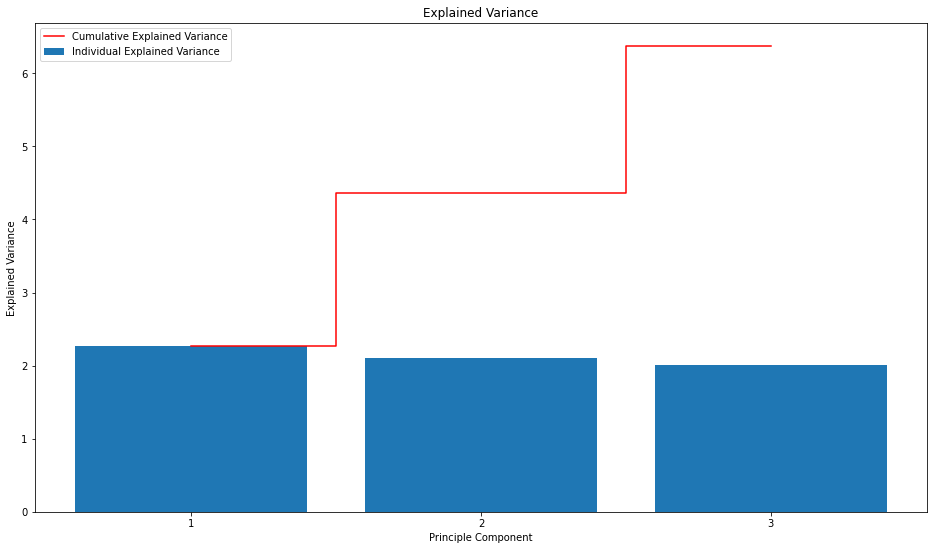

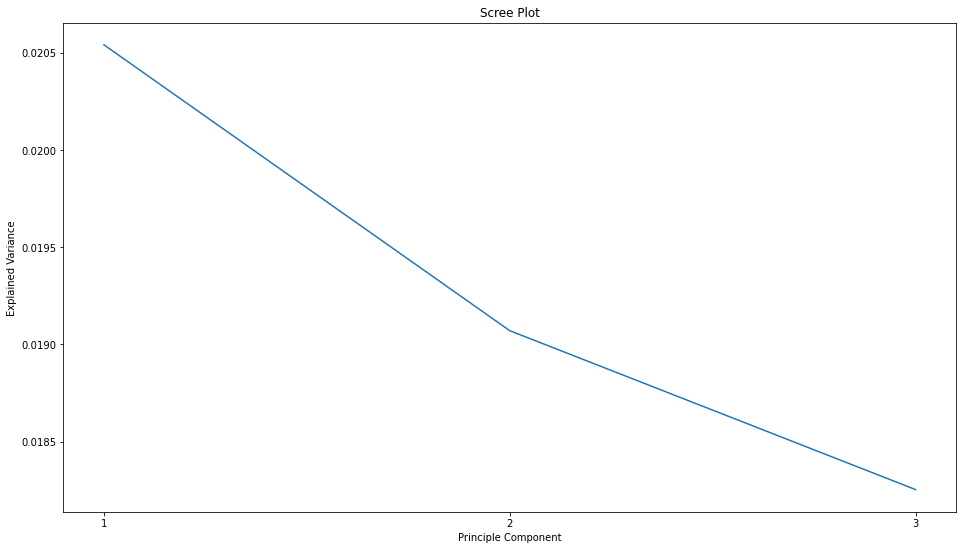

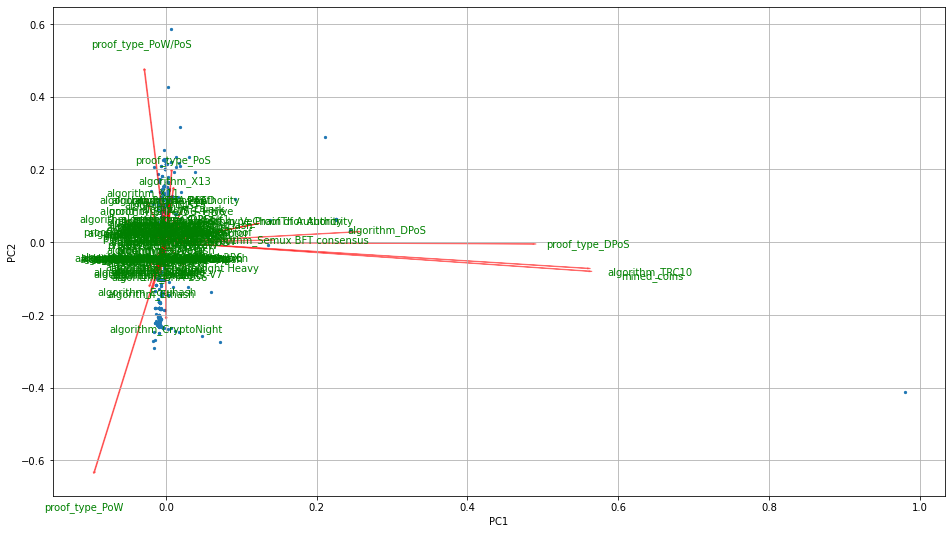

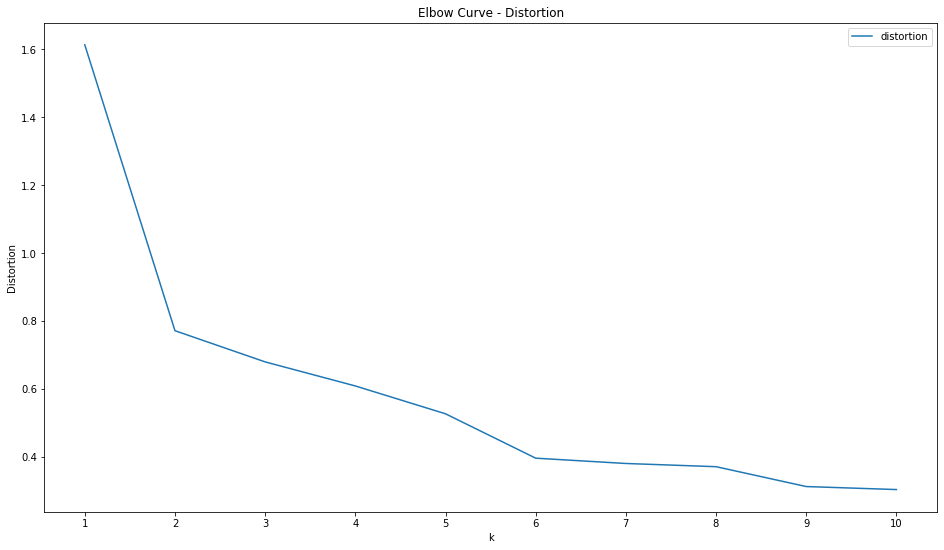

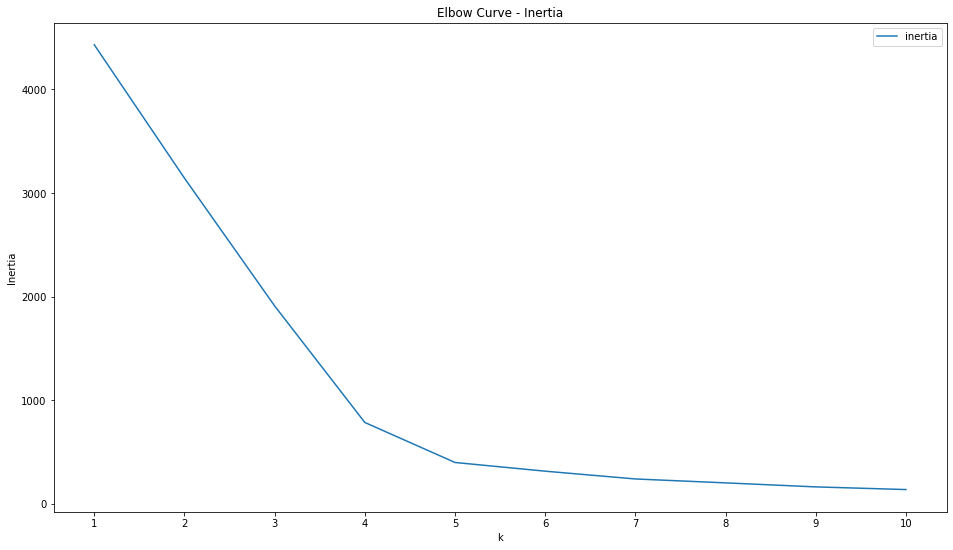

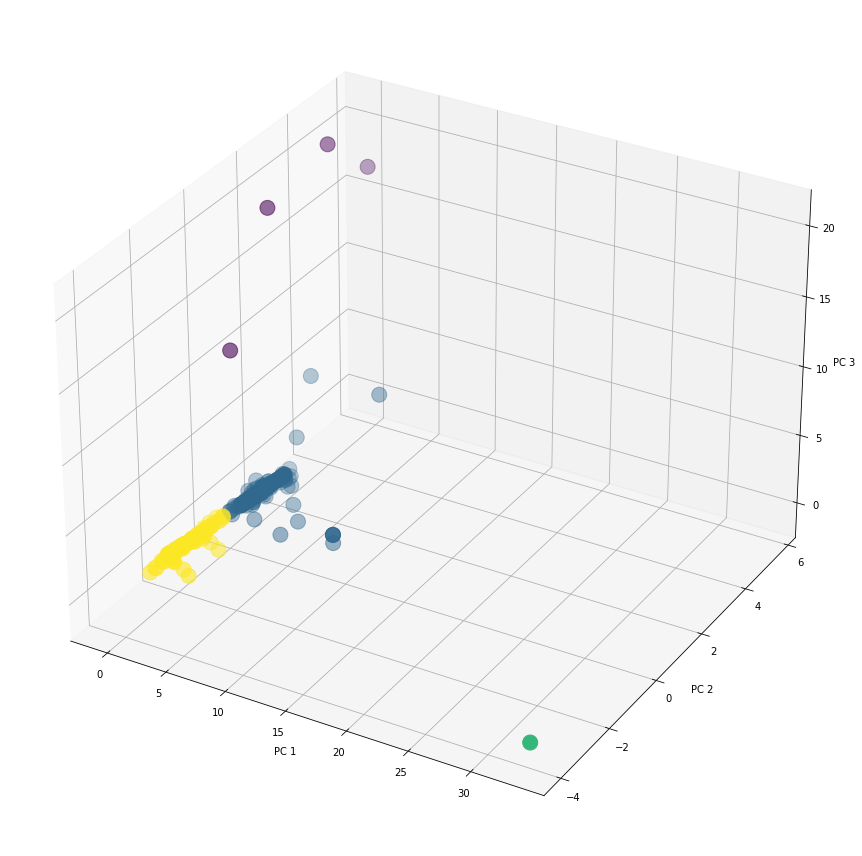

In [110]:
df1 = kmeans_3d_plot(df_encoded)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

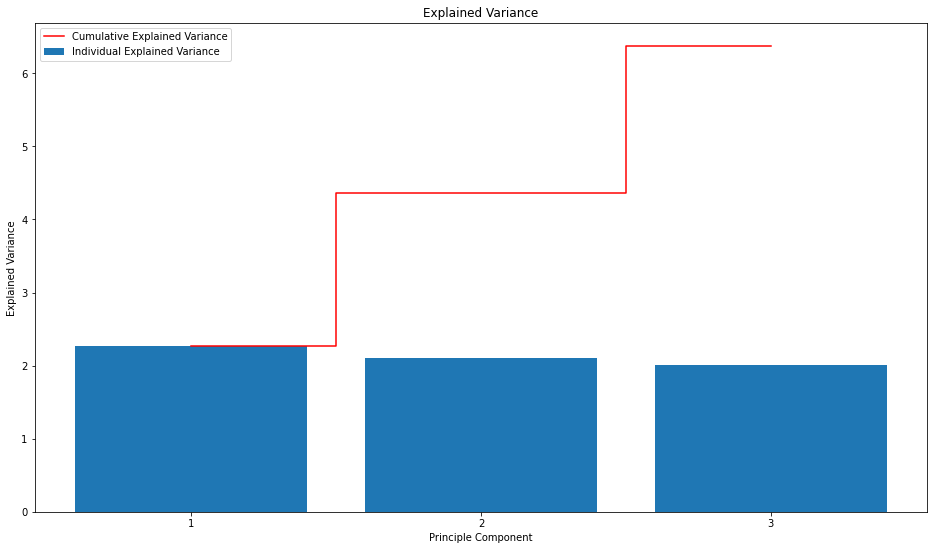

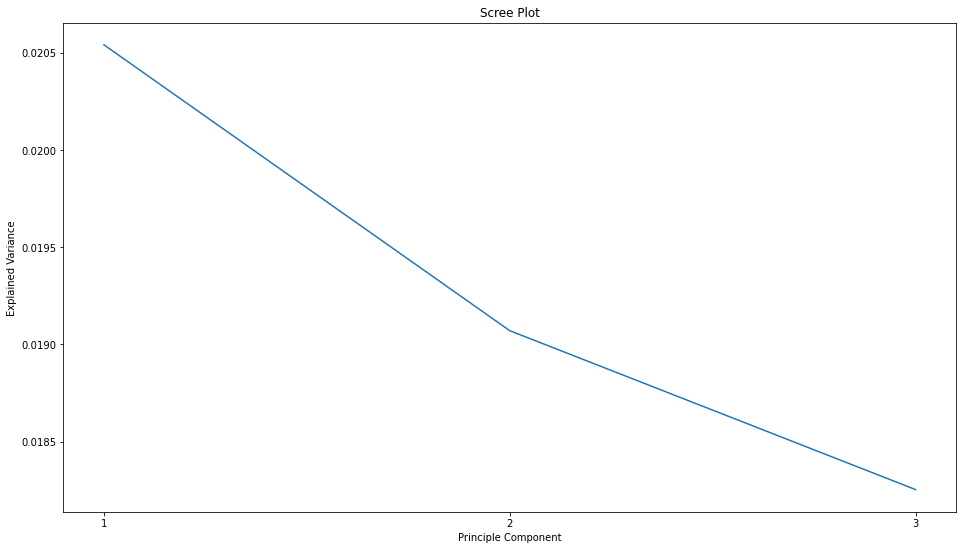

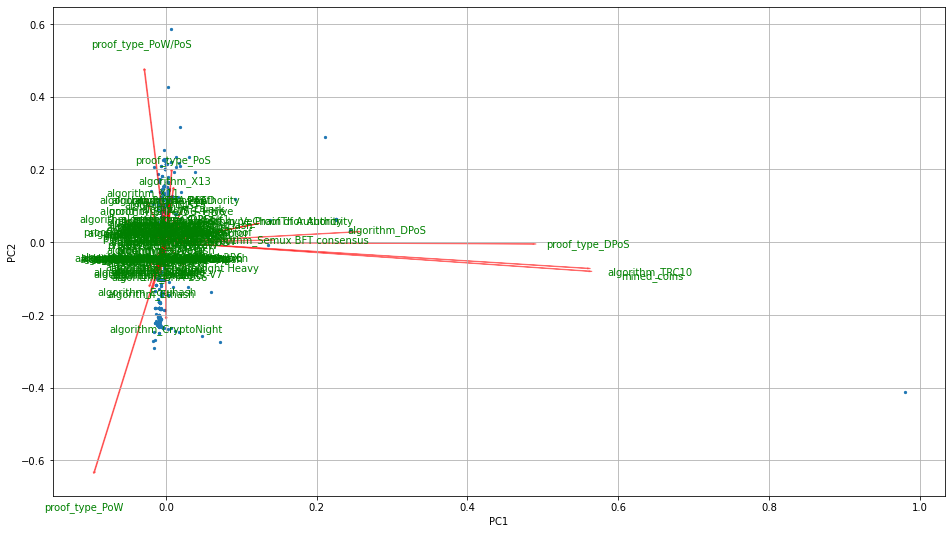

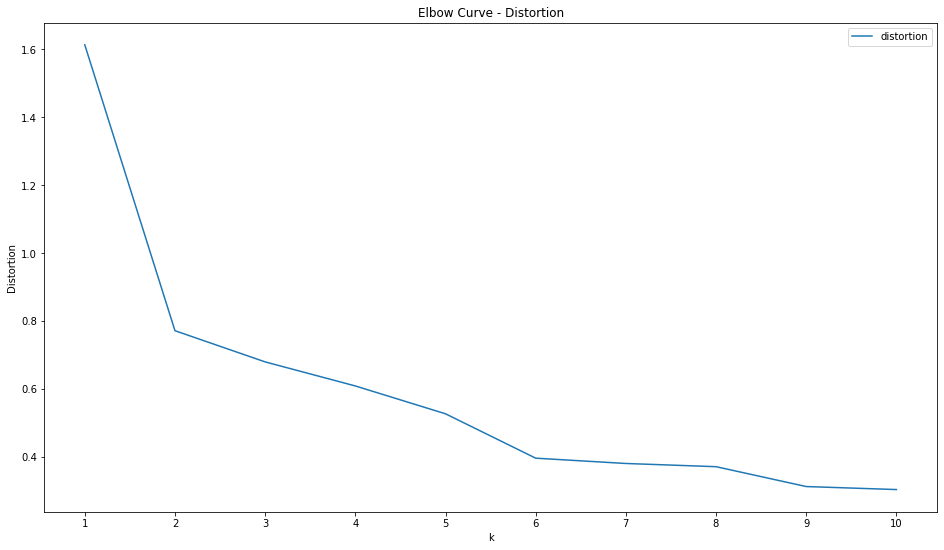

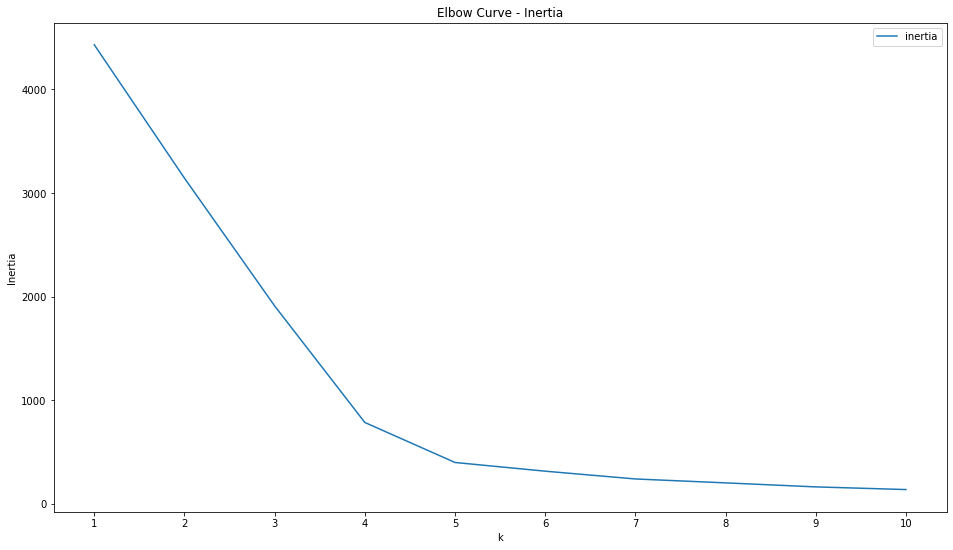

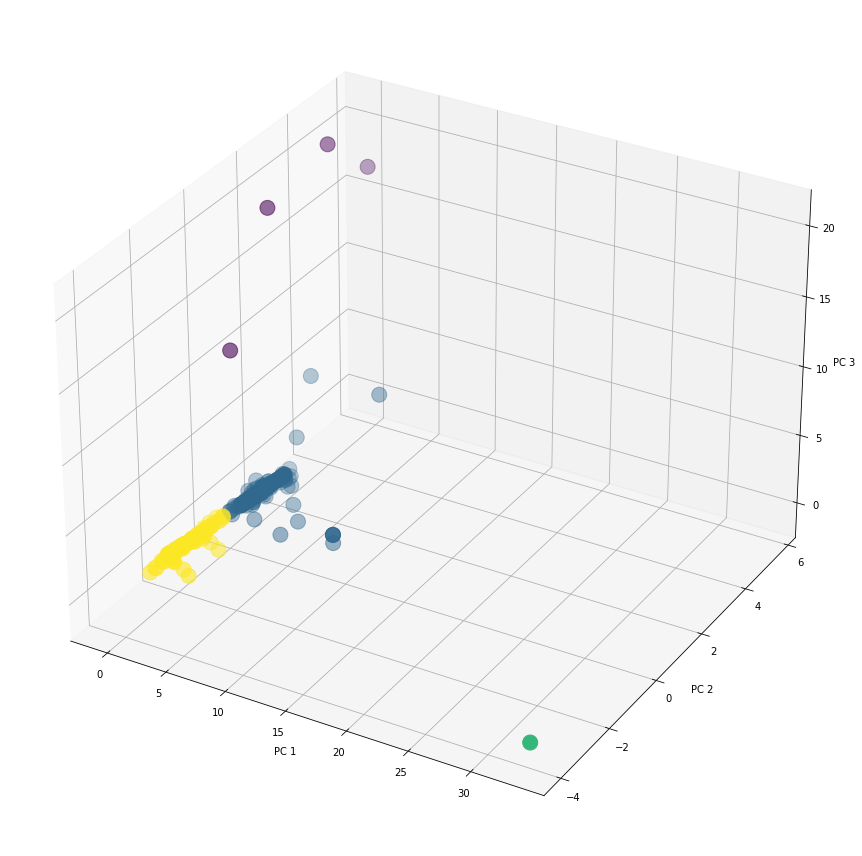

In [111]:
df2 = kmeans_3d_plot(df_base_encoded)

### Compare Clustering Results of One-Hot-Encoded Techniques

In [112]:
# limit columns from results of first test
df1_1 = df1[['CoinName', 'Class', "PC 1", "PC 2", "PC 3"]]

In [113]:
# limit columns from results of second test
df2_1 = df2[['CoinName', 'Class', "PC 1", "PC 2", "PC 3"]]

In [114]:
# Merge results based on common column - CoinName
df_merged = df1_1.merge(df2_1, on='CoinName', suffixes=['_corrected', '_uncorrected'])
df_merged.head()

,CoinName,Class_corrected,PC 1_corrected,PC 2_corrected,PC 3_corrected,Class_uncorrected,PC 1_uncorrected,PC 2_uncorrected,PC 3_uncorrected
0,42 Coin,1,-0.147118,1.290497,-0.467493,1,-0.147118,1.290497,-0.467493
1,404Coin,1,-0.132216,1.288242,-0.467745,1,-0.132216,1.288242,-0.467745
2,EliteCoin,1,0.440405,1.996679,-0.521179,1,0.440405,1.996679,-0.521179
3,Bitcoin,3,-0.184515,-1.347271,0.182543,3,-0.184515,-1.347271,0.182543
4,Litecoin,3,-0.277481,-0.982124,0.012089,3,-0.277481,-0.982124,0.012089


In [115]:
## Previously the classes didn't match due to seed not set
## No longer an issue - one to one comparision of class_corrected and class_uncorrected
# df_merged['Class_uncorrected_fixed'] = df_merged['Class_uncorrected'].apply(lambda x: 0 if x == 1 else (1 if x == 0 else 2))
# df_merged.head()

In [116]:
df_diff = df_merged[df_merged['Class_corrected'] != df_merged['Class_uncorrected']]
df_diff = df_diff[['CoinName', 'Class_corrected', 'Class_uncorrected', 'PC 1_corrected', 'PC 2_corrected',
       'PC 3_corrected', 'PC 1_uncorrected',
       'PC 2_uncorrected', 'PC 3_uncorrected'
       ]]

df_diff.head()

,CoinName,Class_corrected,Class_uncorrected,PC 1_corrected,PC 2_corrected,PC 3_corrected,PC 1_uncorrected,PC 2_uncorrected,PC 3_uncorrected
173,DubaiCoin,1,3,-0.053442,0.925242,-0.297052,-0.375643,-2.139033,0.282878
174,DubaiCoin,3,1,-0.375643,-2.139033,0.282878,-0.053442,0.925242,-0.297052


In [117]:
# unmerge dataset and rename columns
corrected = df_diff[['CoinName', 'Class_corrected', 'PC 1_corrected', 'PC 2_corrected', 'PC 3_corrected']]
corrected.columns = ['CoinName', 'Class', 'PC 1', 'PC 2', 'PC 3']
uncorrected = df_diff[['CoinName', 'Class_uncorrected', 'PC 1_uncorrected', 'PC 2_uncorrected', 'PC 3_uncorrected']]
uncorrected.columns = ['CoinName', 'Class', 'PC 1', 'PC 2', 'PC 3']

In [118]:
# stack datasets
plot_df = pd.concat([corrected,uncorrected],axis=0)

In [119]:
# add id aka index to dataframe
plot_df.reset_index(inplace=True)

In [120]:
# show all mismatch values
plot_df

,index,CoinName,Class,PC 1,PC 2,PC 3
0,173,DubaiCoin,1,-0.053442,0.925242,-0.297052
1,174,DubaiCoin,3,-0.375643,-2.139033,0.282878
2,173,DubaiCoin,3,-0.375643,-2.139033,0.282878
3,174,DubaiCoin,1,-0.053442,0.925242,-0.297052


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

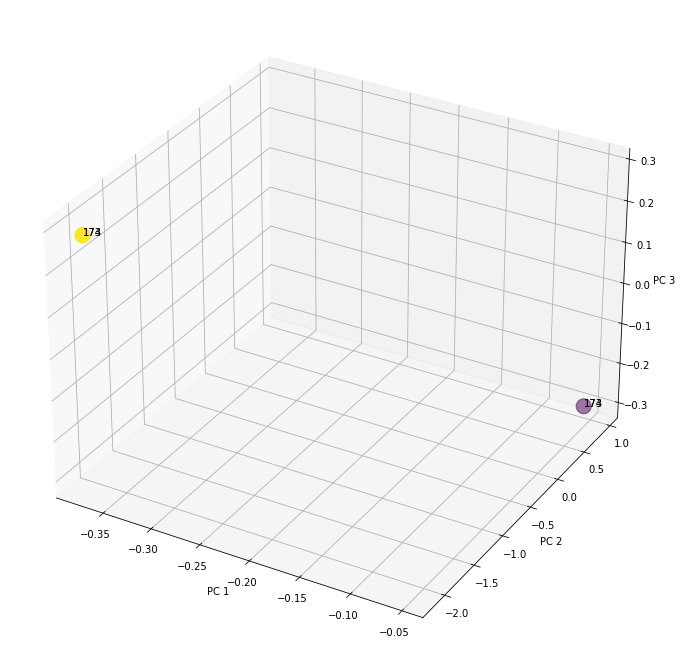

In [121]:
# plot mismatch classes on the same scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

xs = plot_df['PC 1']
ys = plot_df['PC 2']
zs = plot_df['PC 3']
m = list(plot_df['index'])
c = list(plot_df['Class'])

# color_map = plt.get_cmap('spring')

ax.scatter(xs, ys, zs, c=c, s=225)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

for x, y, z, m in zip(xs, ys, zs, m):
    label = f'{m}'
    ax.text(x, y, z, label)

plt.show()

* Looks like pairs of data points overlapping
* After setting the seed for PCA and KMEANS, the results between the tests are consistently two predictions

### Brief Analysis of Clusters

In [122]:
df1.head()

,is_trading,mined_coins,total_coins,algorithm_1GB AES Pattern Search,algorithm_536,algorithm_Argon2,algorithm_BLAKE256,algorithm_Blake,algorithm_Blake2S,algorithm_Blake2b,...,proof_type_Proof of Authority,proof_type_Proof of Trust,proof_type_TPoS,proof_type_Zero-Knowledge Proof,proof_type_dPoW/PoW,PC 1,PC 2,PC 3,CoinName,Class
name,,,,,,,,,,,,,,,,,,,,,
42 Coin,1,4.199995e+01,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.147118,1.290497,-0.467493,42 Coin,1
404Coin,1,1.055185e+09,532000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.132216,1.288242,-0.467745,404Coin,1
EliteCoin,1,2.927942e+10,314159265359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.440405,1.996679,-0.521179,EliteCoin,1
Bitcoin,1,1.792718e+07,21000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.184515,-1.347271,0.182543,Bitcoin,3
Litecoin,1,6.303924e+07,84000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.277481,-0.982124,0.012089,Litecoin,3


In [123]:
df1.groupby('Class').mean()

,is_trading,mined_coins,total_coins,algorithm_1GB AES Pattern Search,algorithm_536,algorithm_Argon2,algorithm_BLAKE256,algorithm_Blake,algorithm_Blake2S,algorithm_Blake2b,...,proof_type_PoW/nPoS,proof_type_Pos,proof_type_Proof of Authority,proof_type_Proof of Trust,proof_type_TPoS,proof_type_Zero-Knowledge Proof,proof_type_dPoW/PoW,PC 1,PC 2,PC 3
Class,,,,,,,,,,,,,,,,,,,,,
0,1.000000,-1.243779e+09,1.548115e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065792,2.927727,17.334721
1,0.911357,2.081765e+09,2.675057e+14,0.000000,1.927978,0.000000,0.963989,0.000000,1.927978,0.000000,...,1.927978,1.927978,1.927978,1.927978,1.927978,1.927978,0.000000,0.115859,1.258539,-0.319208
2,1.000000,9.899887e+11,9.900000e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.285359,-3.977618,-0.823836
3,0.918182,2.704246e+09,3.043845e+15,2.109091,0.000000,2.109091,1.054545,2.109091,0.000000,2.109091,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.109091,-0.228405,-1.400200,0.141573


In [124]:
df1.groupby('Class').count()['total_coins']

Class
0      4
1    361
2      1
3    330
Name: total_coins, dtype: int64

### Summary  

**Low Count Clusters**
* Looks like Group 0 is of crypto that has not been mined but has large total coins - Maybe call this the New Currencies
* Looks like Cluster 2 is of one cryto currency that is highly mined and nearly depleted - maybe call this the Matured Currencies  

**High Count Clusters**
* Cass 1 and Class 3 indicate that these are established cryto currencies.
* Proof_type and algorithm seem to be independent in the above analysis but need to check to see if there is a relationship within each cluster.


In [125]:
df1.head()

,is_trading,mined_coins,total_coins,algorithm_1GB AES Pattern Search,algorithm_536,algorithm_Argon2,algorithm_BLAKE256,algorithm_Blake,algorithm_Blake2S,algorithm_Blake2b,...,proof_type_Proof of Authority,proof_type_Proof of Trust,proof_type_TPoS,proof_type_Zero-Knowledge Proof,proof_type_dPoW/PoW,PC 1,PC 2,PC 3,CoinName,Class
name,,,,,,,,,,,,,,,,,,,,,
42 Coin,1,4.199995e+01,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.147118,1.290497,-0.467493,42 Coin,1
404Coin,1,1.055185e+09,532000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.132216,1.288242,-0.467745,404Coin,1
EliteCoin,1,2.927942e+10,314159265359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.440405,1.996679,-0.521179,EliteCoin,1
Bitcoin,1,1.792718e+07,21000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.184515,-1.347271,0.182543,Bitcoin,3
Litecoin,1,6.303924e+07,84000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.277481,-0.982124,0.012089,Litecoin,3


In [126]:
# Merge classes with original dataframe
df_temp = df1[['Class']]
df_orig_classed = df_clean.merge(df_temp, left_index=True, right_index=True)
len(df_orig_classed)

698

In [127]:
# quick view
df_orig_classed.head(2)

,algorithm,is_trading,proof_type,mined_coins,total_coins,Class
name,,,,,,
ClubCoin,Scrypt,True,PoW/PoS,1.036219e+08,160000000,1
16BitCoin,NIST5,True,PoW/PoS,0.000000e+00,16000000,1


In [128]:
# Check if proof type has strong relationship with class
# Need to validate these numbers
df_orig_classed.groupby(['proof_type','Class']).count()['algorithm']

proof_type            Class
DPOS                  1          1
DPoC                  0          1
DPoS                  1          7
                      2          1
DPoW                  3          1
HPoW                  1          1
LPoS                  0          1
POBh                  1          1
POS / MN              1          1
PoA                   0          1
PoC                   1          3
PoS                   1        104
                      3          2
PoS/LPoS              1          1
PoS/PoW               1          2
PoW                   1          1
                      3        326
PoW + Hive            0          1
PoW and PoS           1          1
PoW/PoS               1        231
                      3          1
PoW/PoS               1          1
PoW/PoW               1          1
PoW/nPoS              1          1
Pos                   1          1
Proof of Authority    1          1
Proof of Trust        1          1
TPoS                  1    

In [129]:
# Check if algorithm has strong relationship with class
temp = df_orig_classed.groupby(['algorithm','Class']).count()['proof_type']

# display all results
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(temp)

algorithm               Class
1GB AES Pattern Search  3          1
536                     1          1
Argon2                  3          1
BLAKE256                1          1
                        3          1
Blake                   3          6
Blake2S                 1          1
Blake2b                 3          1
C11                     1          1
                        3          1
Cloverhash              3          1
Counterparty            1          1
CryptoNight             3         24
CryptoNight Heavy       3          2
CryptoNight Heavy X     3          1
CryptoNight-Lite        3          1
CryptoNight-V7          3          4
Cryptonight-GPU         3          1
DPoS                    1          5
Dagger                  3          3
Dagger-Hashimoto        1          1
                        3          1
ECC 256K1               1          1
Equihash                1          2
                        3         18
Equihash+Scrypt         3          1
Equihash

In [130]:
df_orig_classed

,algorithm,is_trading,proof_type,mined_coins,total_coins,Class
name,,,,,,
ClubCoin,Scrypt,True,PoW/PoS,1.036219e+08,160000000,1
16BitCoin,NIST5,True,PoW/PoS,0.000000e+00,16000000,1
1717 Masonic Commemorative Token,Ethash,True,PoS,1.618033e+06,1618033,3
1Credit,Scrypt,True,PoW,8.821300e+04,92000000000,3
404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000,1
...,...,...,...,...,...,...
eBoost,Scrypt,True,PoW,9.999000e+07,100000000,3
gCn Coin,Scrypt,True,PoW,1.630551e+11,200000000000,3
iBankCoin,Scrypt,True,PoW/PoS,4.526324e+06,44333333,1


In [131]:
# Check if algorithm has strong relationship with class
temp = df_orig_classed.groupby(['algorithm','proof_type','Class']).count()['is_trading']

# display all results
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(temp)

algorithm               proof_type            Class
1GB AES Pattern Search  PoW                   3          1
536                     PoW/PoS               1          1
Argon2                  PoW                   3          1
BLAKE256                PoW                   3          1
                        PoW/PoS               1          1
Blake                   PoS                   3          1
                        PoW                   3          5
Blake2S                 PoW/PoS               1          1
Blake2b                 PoW                   3          1
C11                     PoW                   3          1
                        PoW/PoS               1          1
Cloverhash              PoW                   3          1
Counterparty            PoS                   1          1
CryptoNight             PoW                   3         24
CryptoNight Heavy       PoW                   3          2
CryptoNight Heavy X     PoW                   3          1
Cryp

In [132]:
temp = df1.groupby('Class').mean().loc[[1,3],:].transpose()

# display all results
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       'float_format', '{:.2f}'.format,
                       ):
    print(temp)

Class                                             1                   3
is_trading                                     0.91                0.92
mined_coins                           2081765073.66       2704246422.19
total_coins                      267505684565416.16 3043845081795660.50
algorithm_1GB AES Pattern Search               0.00                2.11
algorithm_536                                  1.93                0.00
algorithm_Argon2                               0.00                2.11
algorithm_BLAKE256                             0.96                1.05
algorithm_Blake                                0.00                2.11
algorithm_Blake2S                              1.93                0.00
algorithm_Blake2b                              0.00                2.11
algorithm_C11                                  0.96                1.05
algorithm_Cloverhash                           0.00                2.11
algorithm_Counterparty                         1.93             

* mined_coins and total_coins have the most influence.  
* is_trading is not represented differently in the two clusters
* Each algorithm shows a couple proof of types from the above groupby's.
* This is also reflected directly above with multiple algorithm variables in Cluster 1 and Cluster 3.
* Very few proof_type variables are in both Cluster 1 and Cluster 3 - it looks like POW are in Cluster 3 and POS and hybrid types are in Cluster 1

<IPython.core.display.Javascript object>

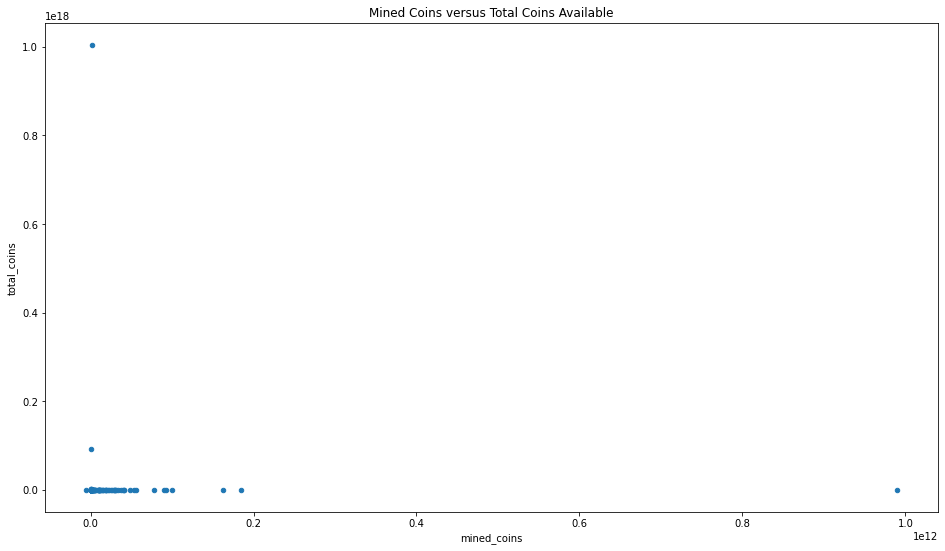

In [133]:
# plot mined_coins versus total_coins
df_orig_classed.plot(kind='scatter', x='mined_coins', y='total_coins', title="Mined Coins versus Total Coins Available", figsize=(16,9));
plt.savefig("./images/two-feature-plot.jpg", dpi=150)